Add Robin boundary conditions.

ds has some problem

Author: yanjun zhang

# ds needs define correct

## 1: Start

Source from 
book "Abali - 2017 - Computational Reality" P119

In [1]:
import pyvista
import ufl
import dolfinx
import time
import numpy as np
import matplotlib.pyplot as plt
from petsc4py import PETSc
from mpi4py import MPI
import sys

from dolfinx.fem.petsc import LinearProblem,assemble_vector, assemble_matrix, create_vector, apply_lifting, set_bc
from dolfinx import fem, mesh, io, plot, default_scalar_type
from dolfinx.fem import (Constant, dirichletbc, Function, FunctionSpace, 
                         form,  locate_dofs_topological)
from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import  locate_entities, locate_entities_boundary,meshtags
from ufl import (SpatialCoordinate, TestFunction, TrialFunction,
                 dx, grad, inner, Measure, dot, FacetNormal)

from find_com_e import find_common_e

# Start time, Final time ,Time step
t = 0
Total_time = 5
num_steps  = 30
# time step size
dt = Total_time / num_steps  

# initial and brake pad temperature
Ti = 25
Tm = 25

# density (kg.m^-3), capacity (J/Kg.K), conductivity (W/m.K)
t_u = 1e3 # m to mm
rho = 7850 /(t_u**3)
c = 462
k = 48 / t_u

# mu, P_brake, v_angualr , r_disc , heat_distribution
mu = 0.35
P_brake = 246000
v_angualr = 48.3
r_disc = 0.25
heat_distribution = 0.88

# S_or is the original brake pad rubbing area, 200 cm2. 
S_or = 200
S_new = 200

# g is the heat source,unit is w/mm2
g = mu * P_brake * v_angualr * r_disc * heat_distribution *2 /(t_u**2)  * (S_or/S_new) *10
print(v_angualr * r_disc * dt *1000)
print(g)

/home/yanjun/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


2012.4999999999998
18.297971999999998


In [2]:
import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}   \
based on GIT commit:  \
{dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")

DOLFINx version: 0.7.3   based on GIT commit:  ubuntu of https://github.com/FEniCS/dolfinx/


## 2: Mesh

In [3]:
# mesh
filename = "3-10" 
domain, cell_markers, facet_markers = gmshio.read_from_msh(filename+".msh", MPI.COMM_WORLD, 0, gdim=3)

# Define variational problem, Here Lagrange changes to CG, what is CG?
V = fem.FunctionSpace(domain, ('CG', 1))

# initialization
def project(function, space):
    u = TrialFunction(space)
    v = TestFunction(space)
    a = inner(u, v) * dx
    L = inner(function, v) * dx
    problem = LinearProblem(a, L, bcs = [])
    return problem.solve()
    
# u_n is for initial condition and uh is the solver result.
# variable, need to be projected form Q onto V
Q = FunctionSpace(domain, ("DG", 0))
T_init = Function(Q)
T_init.name = "u_n"
T_init.x.array[:] = np.full_like(1, Ti, dtype=default_scalar_type)
u_n = project(T_init,V)
u_n.name = "u_n"

fdim = domain.topology.dim - 1
## bc_disc is zero, no any dirichlete boundary condition
bc_disc = mesh.locate_entities_boundary(
    domain, fdim , lambda x:  np.isclose(x[2], 50) )
bc = fem.dirichletbc(PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_disc), V)

Info    : Reading '3-10.msh'...
Info    : 168 entities
Info    : 10751 nodes
Info    : 43604 elements
Info    : Done reading '3-10.msh'


In [4]:
np.set_printoptions(threshold=np.inf)
print(type(PETSc.ScalarType(Tm)))
print(fem.locate_dofs_topological(V, fdim, bc_disc))
print(bc)

<class 'numpy.float64'>
[]


## 3: Setup output


In [5]:
xdmf = io.XDMFFile(domain.comm, "T4.xdmf", "w")
xdmf.write_mesh(domain)


boundaries = []
for i, (x_c, y_c) in enumerate(zip(x_co, y_co), start=1):
    vari_name = 10*i
    boundaries.append(  (vari_name, lambda x: (x[0]-x_c)**2 + (x[1]-y_c)**2  <= 324)  )

In [6]:
# Create boundary condition
import sys
sys.path.append('/home/yanjun/Documents/FEniCSx/Tutorial/Mesh/')
from rub_co import get_rub_coordinate
x_co, y_co = get_rub_coordinate()

boundary1= (10, lambda x: (x[0]-x_co[0])**2 + (x[1]-y_co[0])**2 <= 324)
boundary2= (20, lambda x: (x[0]-x_co[1])**2 + (x[1]-y_co[1])**2 <= 324) 
boundary3= (30, lambda x: (x[0]-x_co[2])**2 + (x[1]-y_co[2])**2 <= 324)
boundary4= (40, lambda x: (x[0]-x_co[3])**2 + (x[1]-y_co[3])**2 <= 324) 
boundary5= (50, lambda x: (x[0]-x_co[4])**2 + (x[1]-y_co[4])**2 <= 324)
boundary6= (60, lambda x: (x[0]-x_co[5])**2 + (x[1]-y_co[5])**2 <= 324) 
boundary7= (70, lambda x: (x[0]-x_co[6])**2 + (x[1]-y_co[6])**2 <= 324)
boundary8= (80, lambda x: (x[0]-x_co[7])**2 + (x[1]-y_co[7])**2 <= 324) 
boundary9= (90, lambda x: (x[0]-x_co[8])**2 + (x[1]-y_co[8])**2 <= 324)
boundary10= (100, lambda x: (x[0]-x_co[9])**2 + (x[1]-y_co[9])**2 <= 324) 
boundary11= (110, lambda x: (x[0]-x_co[10])**2 + (x[1]-y_co[10])**2 <= 324)
boundary12= (120, lambda x: (x[0]-x_co[11])**2 + (x[1]-y_co[11])**2 <= 324) 
boundary13= (130, lambda x: (x[0]-x_co[12])**2 + (x[1]-y_co[12])**2 <= 324)
boundary14= (140, lambda x: (x[0]-x_co[13])**2 + (x[1]-y_co[13])**2 <= 324) 
boundary15= (150, lambda x: (x[0]-x_co[14])**2 + (x[1]-y_co[14])**2 <= 324)
boundary16= (160, lambda x: (x[0]-x_co[15])**2 + (x[1]-y_co[15])**2 <= 324)
boundary17= (170, lambda x: (x[0]-x_co[16])**2 + (x[1]-y_co[16])**2 <= 324) 
boundary18= (180, lambda x: (x[0]-x_co[17])**2 + (x[1]-y_co[17])**2 <= 324)

boundaries1 = [boundary1,boundary2,boundary3,boundary4,boundary5,boundary6,boundary7,boundary8,boundary9,boundary10,
              boundary11,boundary12,boundary13,boundary14,boundary15,boundary16,boundary17,boundary18]
 
facet_indices1, facet_markers1 = [], [] 
fdim = domain.topology.dim - 1  
for (marker, locator) in boundaries1:
        facets = locate_entities(domain, fdim, locator)   
        facet_indices1.append(facets)
        facet_markers1.append(np.full_like(facets, marker))
facet_indices1 = np.hstack(facet_indices1).astype(np.int32)
facet_markers1 = np.hstack(facet_markers1).astype(np.int32)
            
A1 = facet_indices1
B = facet_markers1 
C = mesh.locate_entities_boundary( domain, fdim , lambda x:  np.isclose(x[2], 20) )

common_indices1 = np.intersect1d(A1,C)
D = []
for index in common_indices1:
        rows_A1 = np.where(A1 == index)
        D.append( B[rows_A1] )
facet_markers1 = np.concatenate(D)
####################################

boundary20 = (200, lambda x:  x[2] == 20)
facet_indices2, facet_markers2 = [], [] 
fdim = domain.topology.dim - 1  
for (marker, locator) in [boundary20]:
        facets = locate_entities(domain, fdim, locator)   
        facet_indices2.append(facets)
        facet_markers2.append(np.full_like(facets, marker)) 
facet_indices2 = np.hstack(facet_indices2).astype(np.int32)
facet_markers2 = np.hstack(facet_markers2).astype(np.int32)

A1 = facet_indices2
B = facet_markers2 
C = mesh.locate_entities_boundary( domain, fdim , lambda x:  np.isclose(x[2], 20) )
common_indices2 = np.intersect1d(A1,C)
D = []
for index in common_indices2:
        rows_A1 = np.where(A1 == index)
        D.append( B[rows_A1] )
facet_markers2 = np.concatenate(D) 
    
common_indices3 = [common_indices1,common_indices2]
facet_markers3 = [facet_markers1,facet_markers2]
common_indices3 = np.concatenate(common_indices3)
facet_markers3 = np.concatenate(facet_markers3)
    
facet_tag = meshtags(domain, fdim, common_indices3, facet_markers3)
ds = Measure('ds', domain=domain, subdomain_data=facet_tag) 


In [7]:
print(common_indices3)
print(facet_markers3)

[23667 24713 24716 24895 24897 24900 25237 25238 25239 25395 25553 26005
 26105 26112 26185 27096 27097 27100 27136 27348 27368 27369 27707 27708
 27709 27811 27812 27876 27880 28030 28055 28187 28188 28231 28232 28445
 28448 28517 28525 28574 28691 28955 29111 29113 29161 29162 29248 29509
 29511 30168 30626 30628 30897 30900 30970 31077 31078 31210 31213 31272
 31330 31455 31470 31538 31540 31576 31579 31641 31643 31751 31753 31761
 31766 31823 32035 32038 32096 32153 32264 32288 32332 32416 32548 32554
 32557 32773 32805 33090 33473 33475 33480 33695 33846 34291 34340 34341
 34343 34628 34932 35060 35091 35184 35185 35187 35190 35807 35809 35814
 35914 36722 37039 37044 37262 37593 37595 37598 37701 37702 37797 37883
 37921 38062 38063 38257 38260 38309 38311 38314 38322 38421 38569 38584
 38588 38611 38612 38760 38761 38838 38841 38953 38956 38986 39058 39338
 39341 39345 39805 40556 40560 40748 41030 41032 41267 41268 41270 41388
 41508 41538 41539 41575 41751 41924 41994 42090 42

print('length of facet_indicies_o is: \n',len(facet_indices))
print('length of facet_markers is: \n',len(facet_markers))

print('length of sortec_facet is: \n', len(sorted_facets))
print('length of sortec_markers is: \n',len(facet_markers[sorted_facets]))

np.set_printoptions(threshold=np.inf)
print('facet_markers[sorted_facets] is: \n',facet_markers[sorted_facets])
#print(facet_indices[sorted_facets_indicies])


#print(facet_indices)
boundary19= (190, lambda x: (x[0])**2 + (x[1])**2 <= 320**2)
boundaries1 = boundaries + [boundary19]

facet_indices1, facet_markers1 = [], [] 
fdim = domain.topology.dim - 1  
for (marker, locator) in boundaries1:
    facets = locate_entities(domain, fdim, locator)
    facet_indices1.append(facets)
    facet_markers1.append(np.full_like(facets, marker))

bc_disc1 = mesh.locate_entities_boundary(
    domain, fdim , lambda x:  np.isclose(x[2], 20) )

facet_indices1 = np.hstack(facet_indices1).astype(np.int32)
facet_markers1 = np.hstack(facet_markers1).astype(np.int32)

facet_indices1 = np.intersect1d(bc_disc1, facet_indices1)
sorted_facets1 = np.argsort(facet_indices1)

print(len(sorted_facets1))
print(len(facet_markers[sorted_facets1]))
print(type(facet_markers1))
print(len(bc_disc1))
np.set_printoptions(threshold=np.inf)
print(facet_markers[sorted_facets1])

## 4: Variational equation


In [8]:
uh = fem.Function(V)
uh.name = "uh"
uh = project(T_init,V)
xdmf.write_function(uh, t)

u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
n = FacetNormal(domain)
h = g/20


#a = (rho*c)/dt*inner(u,v)*dx + k*inner(grad(u),grad(v))*dx +  h * inner( u, v) *ds(20)
a = (rho*c)/dt*inner(u,v)*dx + k*inner(grad(u),grad(v))*dx 
#L = inner(f,v) *dx + (rho*c)/dt * inner(u_n, v) * dx  +  h * 25* v *ds(20)
L = inner(f,v) *dx + (rho*c)/dt * inner(u_n, v) * dx  

for i in list(range(1,2)):
     a +=   -  k * dot( grad(u)* v, n) *ds(10*i)
     L +=   +  inner(g, v) *ds(10*i)

# assembly matrix and vector
bilinear_form = fem.form(a)
linear_form = fem.form(L)

A = assemble_matrix(bilinear_form)
A.assemble()
b = create_vector(linear_form)
## 7: Using petsc4py to create a linear solver
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

## 8:Visualization of time dependent problem using pyvista
import matplotlib as mpl
pyvista.start_xvfb()
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
plotter = pyvista.Plotter()
plotter.open_gif("T4.gif", fps=30)
grid.point_data["Temperature"] = uh.x.array
warped = grid.warp_by_scalar("Temperature", factor=0)
viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(title_font_size=25, label_font_size=20,  color="black",
             position_x=0.1, position_y=0.8, width=0.8, height=0.1)
renderer = plotter.add_mesh(warped, show_edges=True, lighting=False,
                            cmap=viridis, scalar_bar_args=sargs,
                            #clim=[0, max(uh.x.array)])
                            clim=[0,  200])

## 5: Solution


1: Rotation has applied for 10 degree. 2: Current time is 0.2 s. 3: Completion is 3.3 %. 

  warnings.warn(

  warnings.warn(



1: Rotation has applied for 300 degree. 2: Current time is 5.0 s. 3: Completion is 100.0 %. 


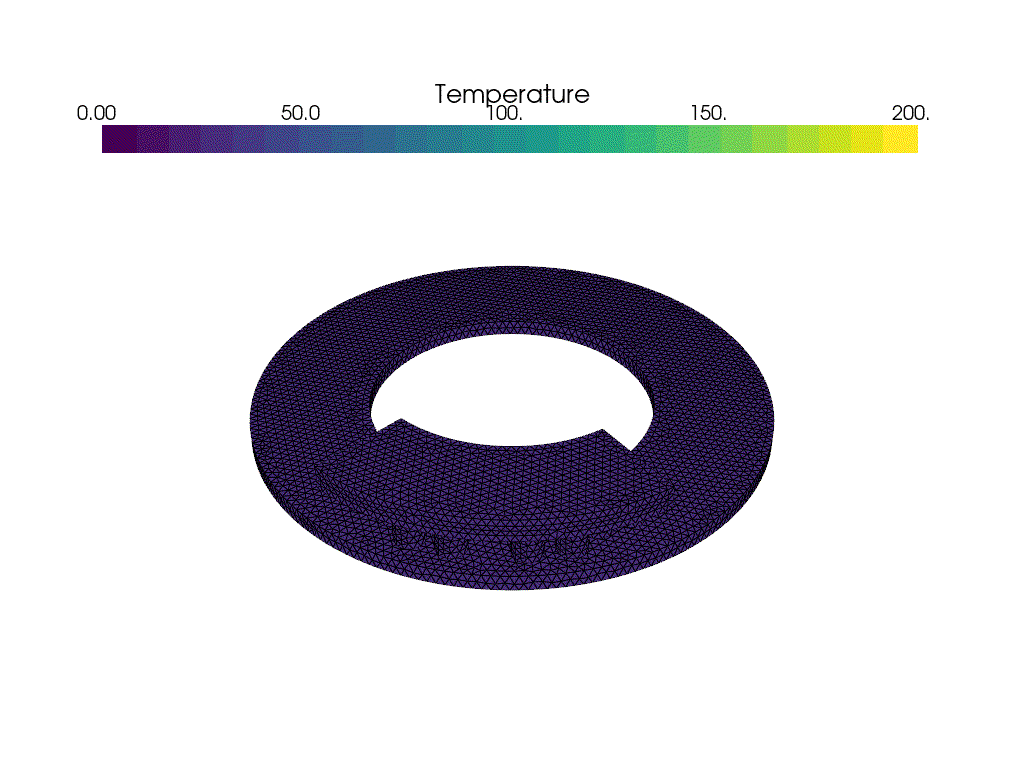

In [9]:
from rotation_co import rub_rotation
import numpy as np

degree = 10
total_degree = 0

for i in range(num_steps):
    t += dt
   
    boundaries1 = []
    x_co, y_co = rub_rotation (x_co, y_co, degree)   # update the location
    total_degree += degree  # Incrementing degree by 10 in each step
    
    sys.stdout.write('\r1: Rotation has applied for {} degree. '.format(total_degree))
    sys.stdout.write('2: Current time is ' + str(round(t,1)) + " s. ")
    sys.stdout.write('3: Completion is '  + str(round (100*(t/Total_time),1) )+ " %. ")
    sys.stdout.flush()
    
    boundary1= (10, lambda x: (x[0]-x_co[0])**2 + (x[1]-y_co[0])**2 <= 324)
    boundary2= (20, lambda x: (x[0]-x_co[1])**2 + (x[1]-y_co[1])**2 <= 324) 
    boundary3= (30, lambda x: (x[0]-x_co[2])**2 + (x[1]-y_co[2])**2 <= 324)
    boundary4= (40, lambda x: (x[0]-x_co[3])**2 + (x[1]-y_co[3])**2 <= 324) 
    boundary5= (50, lambda x: (x[0]-x_co[4])**2 + (x[1]-y_co[4])**2 <= 324)
    boundary6= (60, lambda x: (x[0]-x_co[5])**2 + (x[1]-y_co[5])**2 <= 324) 
    boundary7= (70, lambda x: (x[0]-x_co[6])**2 + (x[1]-y_co[6])**2 <= 324)
    boundary8= (80, lambda x: (x[0]-x_co[7])**2 + (x[1]-y_co[7])**2 <= 324) 
    boundary9= (90, lambda x: (x[0]-x_co[8])**2 + (x[1]-y_co[8])**2 <= 324)
    boundary10= (100, lambda x: (x[0]-x_co[9])**2 + (x[1]-y_co[9])**2 <= 324) 
    boundary11= (110, lambda x: (x[0]-x_co[10])**2 + (x[1]-y_co[10])**2 <= 324)
    boundary12= (120, lambda x: (x[0]-x_co[11])**2 + (x[1]-y_co[11])**2 <= 324) 
    boundary13= (130, lambda x: (x[0]-x_co[12])**2 + (x[1]-y_co[12])**2 <= 324)
    boundary14= (140, lambda x: (x[0]-x_co[13])**2 + (x[1]-y_co[13])**2 <= 324) 
    boundary15= (150, lambda x: (x[0]-x_co[14])**2 + (x[1]-y_co[14])**2 <= 324)
    boundary16= (160, lambda x: (x[0]-x_co[15])**2 + (x[1]-y_co[15])**2 <= 324)
    boundary17= (170, lambda x: (x[0]-x_co[16])**2 + (x[1]-y_co[16])**2 <= 324) 
    boundary18= (180, lambda x: (x[0]-x_co[17])**2 + (x[1]-y_co[17])**2 <= 324)
   
    boundaries1 = [boundary1,boundary2,boundary3,boundary4,boundary5,boundary6,boundary7,boundary8,boundary9,boundary10,
              boundary11,boundary12,boundary13,boundary14,boundary15,boundary16,boundary17,boundary18]
    #boundaries = boundaries+ [boundary19]
 
    facet_indices1, facet_markers1 = [], [] 
    fdim = domain.topology.dim - 1  
    for (marker, locator) in boundaries1:
        facets = locate_entities(domain, fdim, locator)   
        facet_indices1.append(facets)
        facet_markers1.append(np.full_like(facets, marker))  
    facet_indices1 = np.hstack(facet_indices1).astype(np.int32)
    facet_markers1 = np.hstack(facet_markers1).astype(np.int32)
    bc_disc = mesh.locate_entities_boundary( domain, fdim , lambda x:  np.isclose(x[2], 20) )        
    A1 = facet_indices1
    B = facet_markers1 
    C = bc_disc
    common_indices1 = np.intersect1d(A1,C)
    D = []
    for index in common_indices1:
        rows_A1 = np.where(A1 == index)
        D.append( B[rows_A1] )
    facet_markers1 = np.concatenate(D)
    ####################################

    
    boundary20 = (200, lambda x:  x[2] == 20)
    facet_indices2, facet_markers2 = [], [] 
    fdim = domain.topology.dim - 1  
    for (marker, locator) in [boundary20]:
        facets = locate_entities(domain, fdim, locator)   
        facet_indices2.append(facets)
        facet_markers2.append(np.full_like(facets, marker)) 
    facet_indices2 = np.hstack(facet_indices2).astype(np.int32)
    facet_markers2 = np.hstack(facet_markers2).astype(np.int32) 
    A1 = facet_indices2
    B = facet_markers2 
    C = bc_disc
    common_indices2 = np.intersect1d(A1,C)
    D = []
    for index in common_indices2:
        rows_A1 = np.where(A1 == index)
        D.append( B[rows_A1] )
    facet_markers2 = np.concatenate(D)  
    
    common_indices3 = [common_indices1,common_indices2]
    facet_markers3 = [facet_markers1,facet_markers2]
    common_indices3 = np.concatenate(common_indices3)
    facet_markers3 = np.concatenate(facet_markers3)
    
    facet_tag = meshtags(domain, fdim, common_indices3, facet_markers3)
    ds = Measure('ds', domain=domain, subdomain_data=facet_tag) 
   

    #a = (rho*c)/dt*inner(u,v)*dx + k*inner(grad(u),grad(v))*dx +  h * inner( u, v) *ds(20)
    a = (rho*c)/dt*inner(u,v)*dx + k*inner(grad(u),grad(v))*dx 
    #L = inner(f,v) *dx + (rho*c)/dt * inner(u_n, v) * dx  +  h * 25* v *ds(20)
    L = inner(f,v) *dx + (rho*c)/dt * inner(u_n, v) * dx  

    for i in list(range(10,12)):
        a +=   -  k * dot( grad(u)*v, n) *ds(10*i)
        L +=   +  inner(g, v) *ds(10*i)
    
    bilinear_form = fem.form(a)
    linear_form = fem.form(L)
    b = create_vector(linear_form)
    A = assemble_matrix(bilinear_form, bcs=[bc])
    A.assemble()
    solver = PETSc.KSP().create(domain.comm)
    solver.setOperators(A)
    solver.setType(PETSc.KSP.Type.PREONLY)
    solver.getPC().setType(PETSc.PC.Type.LU)
    
    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    assemble_vector(b, linear_form)
    # Apply Dirichlet boundary condition to the vector
    apply_lifting(b, [bilinear_form], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])
    # Solve linear problem
    solver.solve(b, uh.vector)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array
    # Write solution to file
    xdmf.write_function(uh, t)
    # Update plot
    #warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(uh.x.array, render=False)
    plotter.write_frame()
    
plotter.close() 
xdmf.close()
print()

# Display the GIF
from IPython.display import display, Image
display(Image(filename = 'T4.gif'))

In [10]:
print(a)

{ 0.0217602 * v_1 * (conj((v_0))) } * dx(<Mesh #0>[everywhere], {})
  +  { 0.048 * (conj(((grad(v_0)) : (grad(v_1))))) } * dx(<Mesh #0>[everywhere], {})
  +  { -0.048 * (({ A | A_{i_{67}} = (grad(v_1))[i_{67}] * v_0 }) . (n)) } * ds(<Mesh #0>[100], {})
  +  { -0.048 * (({ A | A_{i_{68}} = (grad(v_1))[i_{68}] * v_0 }) . (n)) } * ds(<Mesh #0>[110], {})


In [11]:
print(L)

{ c_0 * (conj((v_0))) } * dx(<Mesh #0>[everywhere], {})
  +  { 0.0217602 * u_n * (conj((v_0))) } * dx(<Mesh #0>[everywhere], {})
  +  { 18.297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[100], {})
  +  { 18.297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[110], {})


In [12]:
print(common_indices3)

[ 4986  4987  5417  5418  5567  5920  5921  6079  6384  6387  6680  6947
  6949  7896  7897  7941  7944  8256  8500  8501  8531  8734  8739  8812
  8826  8857  8954  9044  9045  9050  9053  9054  9132  9133  9300  9338
  9531  9552  9632  9692  9693  9771  9785  9791  9792  9998 10003 10006
 10300 10311 10754 11774 11779 12067 12228 12324 12326 12401 12403 12738
 12772 12869 12871 12876 12879 12931 12932 13012 13018 13021 13448 13450
 13456 13582 13583 13759 13777 13779 13781 13785 13973 13976 14030 14062
 14063 14174 14178 14445 15077 15082 15085 16025 16026 16029 16036 16240
 16801 16803 16806 16959 17017 17142 17144 17240 17334 17337 17576 17580
 17669 17670 17841 17842 17935 18073 18458 18459 18515 18844 18866 18872
 18875 18912 18956 18957 18958 19454 19455 19570 19673 19674 19798 19799
 20076 20373 20377 20378 20402 20684 20687 21032 21038 21045 21115 21122
 21309 21312 21340 21356 21480 21481 21914 21916 22026 22091 22094 22115
 22337 22338 22404 22940 22955 22956 22994 23094 23

In [13]:
print(facet_markers3)

[ 20  20  20  20  20  20  20  20  20  20  20  20  20  30  30  30  30  30
  10  10  50  10  10  10  10  30  30  30  30  50  50  50  10  10  50  30
  50  30  30  10  10  10  50  50  50  30  50  50  10  10  50  60  60  60
  70  70  70  40  40  60  70  70  70  60  60  40  40  40  60  60  70  70
  70  40  40  40  60  60  60  60  40  40  40  70  70  40  40  70  80  80
  80  80  80  80  80  80  80  80  80  80  80  90  90  90 130 130  90  90
 130 130  90  90 130  90 130 130  90 130  90  90  90  90 130 130 130 120
 120  90 130 130 120 120 120 120 120 120 170 120 120 120 110 110 170 170
 170 170 170 110 120 120 110 110 170 110 110 170 170 170 170 110 110 110
 110 140 140 140 140 140 140 140 140 140 160 160 160 160 140 140 160 160
 160 160 160 150 150 160 160 160 150 150 150 150 150 150 100 100 100 100
 150 150 150 100 100 100 150 150 100 100 100 100 100 180 180 180 180 180
 180 180 180 180 180 180 180 180 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 150 150 18